In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_main=pd.read_csv('df_main.csv')
df_info=pd.read_csv('df_info.csv')
df_scaled=pd.read_csv('df_scaled.csv')
df_r=pd.read_csv('df_r.csv')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#получение признаков
X=df_info[['BR','SBER','Si']]
#получение целевых меток
y=df_info['SNGS']
# делим в пропорции 80 к 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

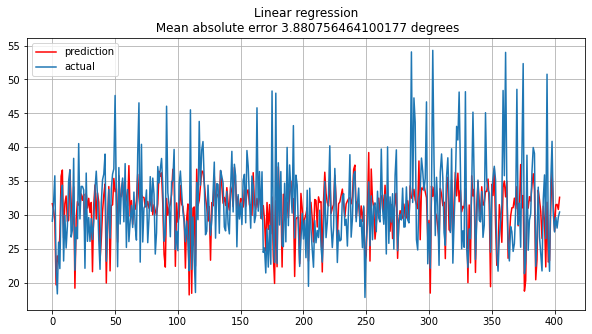

In [7]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [8]:
lr.coef_

array([-1.68370451e-01,  3.20042746e-02,  7.88237923e-05])

In [9]:
lr.intercept_

30.332881177320964

Перейдем к самому интересному: у нас есть прогнозные показатели от ведущих инвест домов мира (или России), и их мы вставим в уравнение линейной регрессии. 

Средневзвешенные прогнозные цены на 2024 год:
1) Нефть Brent - 87
2) Доллар Si - 60 000
3) SBER - 210

In [10]:
y = 30.332881177320836 - 1.68370451e-01*87 + 3.20042746e-02*210 + 7.88237923e-05*60000
y

27.134977144320835

__Прогнозная цена Сургутнефтегаза на 2024 год__

Вставив в модель линейной регрессии такие показатели, как Сбер, нефть Брент и доллар с их значениями от инвестдомов, мы получаем цену в 27 рублей, что вполне соотносится с тем, что в этом году еще предстоит июльский дивгэп, и нынешняя цена в 25 рублей снизится примерно до 23. Так, до 2024 года дивгэп будет закрываться и при предполагаемых рисках (модель уже предвидит постоянный шторм) цена в среднем составит 27,13 рублей.

Теперь оценим нашу модель с помощью некоторых метрик.

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1220
Train MAPE = 0.1172


Mean Absolute Percentage Error дает нам 11-12% ошибки, что является в целом неплохим показателем, можно сказать, что модель релевантна и не переобучена. Что будет, если сделать скалирование данных?

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.1220
Train MAPE = 0.1172


Ничего не изменилась, ошибка все еще небольшая. Попробуем добавить в данные степеней.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

polinom_transform = PolynomialFeatures(3, include_bias=False)

X_train_poly = polinom_transform.fit_transform(X_train)
X_test_poly = polinom_transform.transform(X_test)

In [15]:
model = LinearRegression()

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))

Test MAPE = 0.0954
Train MAPE = 0.0883


Теперь ошибка в районе 8-9%. Это отличный результат ;) Трейн около 8% также показывает, что модель даже после полиномиальных фичей не переобучилась.

Теперь посмотрим с помощью коэффициента детерминации, насколько наше предсказание отличается от наивного прогноза.

In [16]:
from sklearn.metrics import r2_score

print("Test R2 = %.4f" % r2_score(y_test, y_pred))
print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Test R2 = 0.5438
Train R2 = 0.5842


Это немного, но это честная работа..

В целом, можем сказать, что модель предсказывает лучше, чем наивный прогноз.

Попробуем использовать Ридж-регрессию.

In [17]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 5.2514
Train RMSE = 4.7846


In [18]:
model.coef_

array([-1.68370148e-01,  3.20042592e-02,  7.88237792e-05])

In [19]:
model.intercept_

30.33286574250433

Best alpha = 7.8476


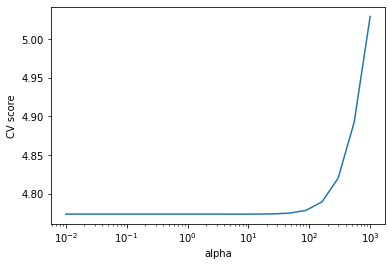

In [20]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

In [21]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 5.2506


In [22]:
forecast = {'BR':[87], 'SBER':[210], 'Si':[60000]} 

X_pred = pd.DataFrame(forecast, index =['2024']) 

y_forecast = model.predict(X_pred)

float(y_forecast)

27.1545573173299

После того, как данные были отскалированы, подобрана по Гридсерчу лучшая альфа, модель снизила таргетную цену для Сургута, но не очень критично. __Мы все еще около адекватной оценки в 27 рублей.__

Судя по метрикам, ошибки у нас небольшие, поэтому модель стала еще более точной.